In [6]:
import segmentation_models_pytorch as smp

# from segmentation_models_pytorch.encoders import get_preprocessing_fn 
# preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU, BCEWithLogitsLoss
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import CenterCrop
from torchvision import transforms
from torchvision.utils import save_image
from torchvision import transforms
import torch.nn.functional as F

import h5py
import glob
import time
import random
import PIL.Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys
import argparse

In [4]:
#change directory in order to access unet library
%cd ..

/home/jovyan


In [5]:
from unet.models import UNetBinary
from unet.utils import *
from unet.train_test import *
from unet.datasets import *

In [10]:
# Parameters to play with in order to get the best results
PIXEL_THRESH = 0.6
PATCH_THRESH = 0.15
# options for unet_type are unet_binart, unet_plusplus and deeplabv3
UNET_TYPE = 'unet_plusplus'
magnification = 10

BATCH_SIZE = 64
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256
#Whether you want to save the results
SAVE = False

In [11]:
#Initialize cuda device 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

model_path = os.path.join(f"unet/unet_model_save/{UNET_TYPE}/{magnification}x/model_latest.pt")
try:
    model = torch.load(model_path)
    model.to(DEVICE)
    print("Successfully loaded model")
except:
    print("ERROR: unable to load model")


Successfully loaded model


In [12]:
#Define paths to datasets
DATASET_DIR = f'data/GR_seg/{magnification}x'
MAGNIFICATION = os.path.basename(DATASET_DIR)
MASKS_DIR = os.path.join(DATASET_DIR, 'masks')
PATCHES_DIR = os.path.join(DATASET_DIR, 'patches')

#Load datasets
X_test, y_test = generate_test_set(PATCHES_DIR, MASKS_DIR, test_split=0.2, random_state=42)
transforms_ds = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
    transforms.ToTensor()
])
test_ds = BinaryGRDataset(X_test, y_test, transforms=transforms_ds)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)

100%|██████████| 56/56 [00:28<00:00,  1.97it/s]


In [13]:
df_results = test(model, DEVICE, test_loader, UNET_TYPE, MAGNIFICATION, pixel_threshold=PIXEL_THRESH, img_positive_threshold=PATCH_THRESH, save=SAVE)
df_results

100%|██████████| 33/33 [00:11<00:00,  2.96it/s]


,pixel_accuracy,pixel_precision,pixel_recall,patches_accuracy,dice_score,mean_iou,false_neg_rate,true_pos_rate,false_pos_rate,test_size,pixel_threshold,img_positive_threshold
0,0.8718,0.90302,0.791049,0.875,0.885606,0.766278,0.159059,0.840941,0.078066,2112,0.6,0.15


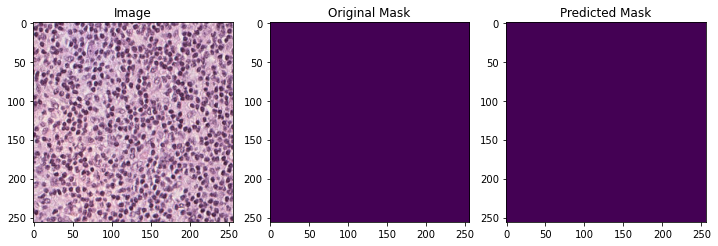

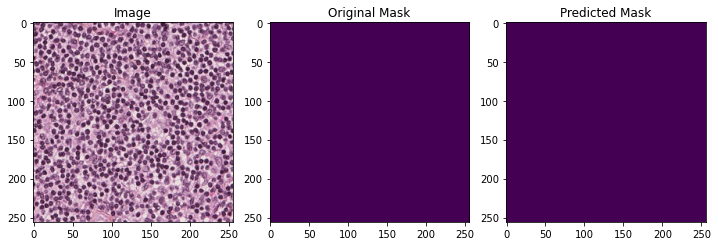

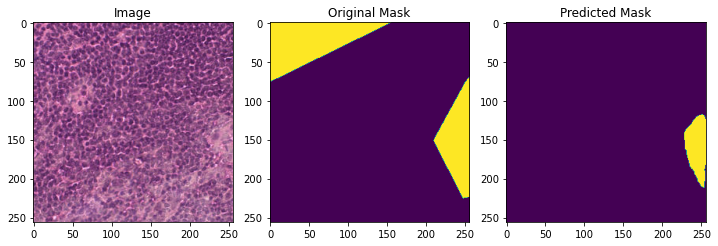

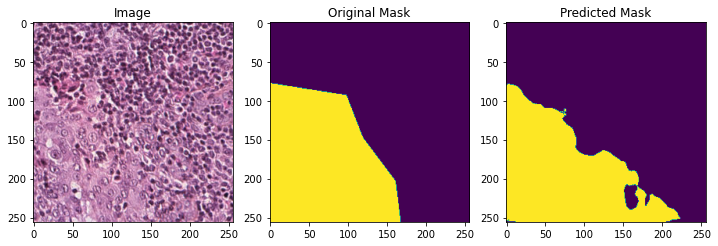

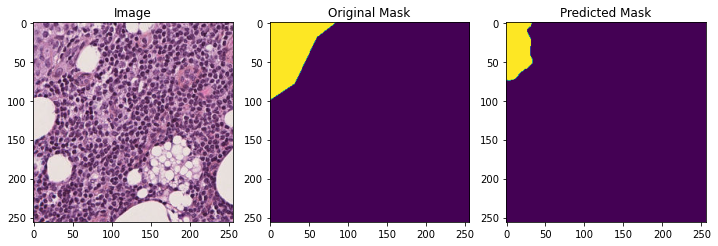

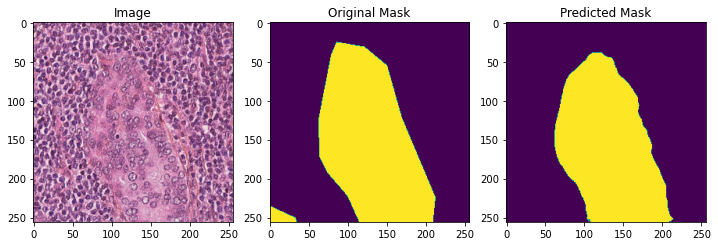

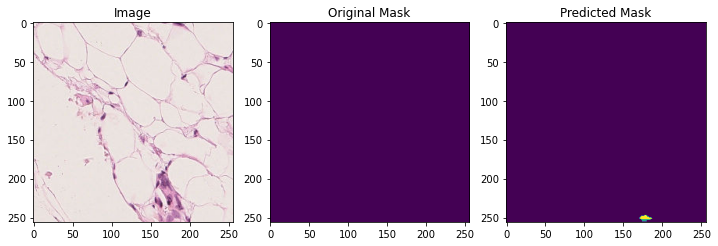

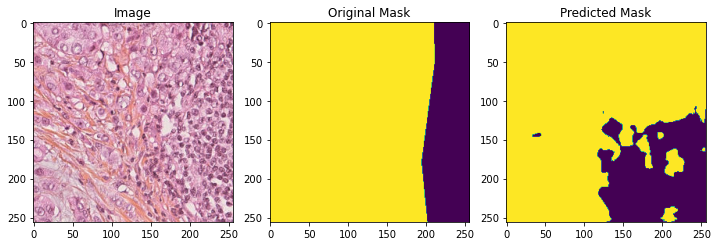

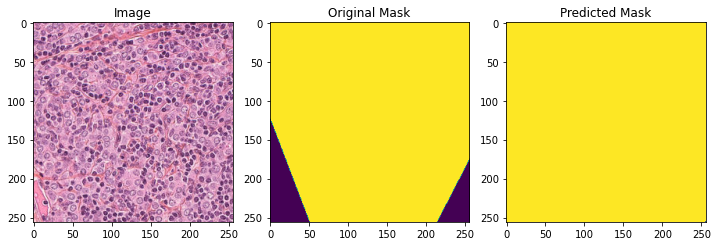

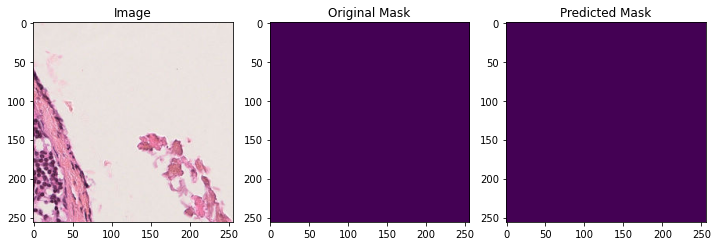

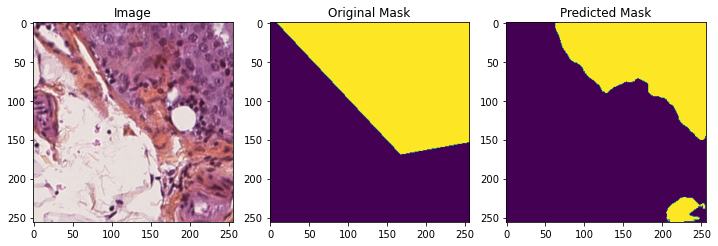

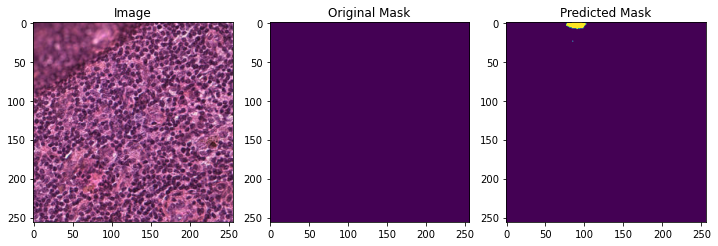

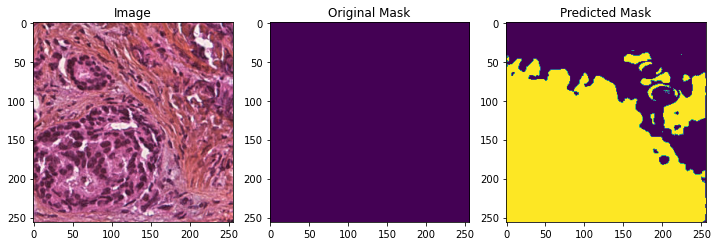

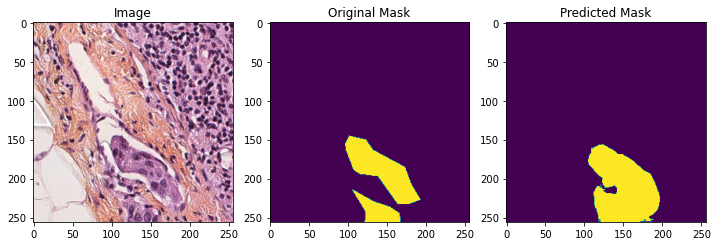

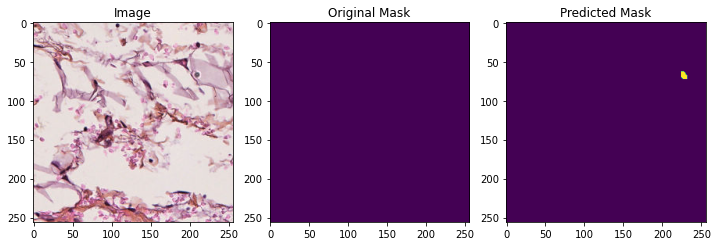

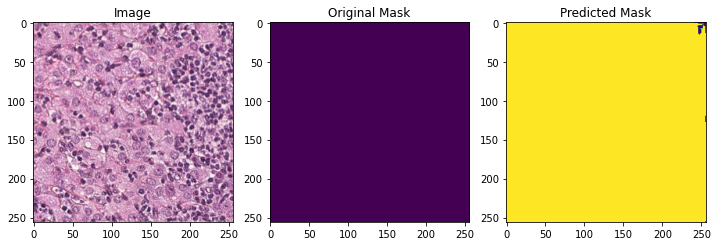

In [14]:
visualize_predictions(model, DEVICE, test_loader, threshold=PIXEL_THRESH, num_examples=15)